In [4]:
from pathlib import Path
import sys
import pandas as pd
import torch
import matplotlib.pyplot as plt
import xarray as xr
import yaml
import geopandas as gpd
import contextily as cx
from adjustText import adjust_text

from neuralhydrology.nh_run import start_run, eval_run, finetune
from neuralhydrology.nh_run import continue_run
from neuralhydrology.utils.config import Config
from neuralhydrology.evaluation import get_tester, metrics

In [5]:
# -------- Paths ---------
CONFIG_PATH = Path("./entire_camels.yml")
RUNS_DIR = Path("runs")
PLOTS_DIR = Path("./evaluation_plots")
RUNS_DIR = Path("runs")
PLOTS_DIR = Path("evaluation_plots")
ATTRIBUTES_FILE= Path('/inputs/data_updated/attributes/attributes_other.csv')

In [6]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU or MacOS with Metal support
if torch.cuda.is_available() or torch.backends.mps.is_available():
    start_run(config_file=Path("entire_camels.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("entire_camels.yml"), gpu=-1)

2026-01-12 23:36:53,693: Logging to /home/azureuser/sky_workdir/precipitation_dir/runs/CAMELS_UY_3_seq_270_30_epochs_seq_270_hidden_256_dropout_04_fb_05_seed111_1201_233653/output.log initialized.
2026-01-12 23:36:53,693: ### Folder structure created at /home/azureuser/sky_workdir/precipitation_dir/runs/CAMELS_UY_3_seq_270_30_epochs_seq_270_hidden_256_dropout_04_fb_05_seed111_1201_233653
2026-01-12 23:36:53,694: ### Run configurations for CAMELS_UY_3_seq_270_30_epochs_seq_270_hidden_256_dropout_04_fb_05_seed111
2026-01-12 23:36:53,696: experiment_name: CAMELS_UY_3_seq_270_30_epochs_seq_270_hidden_256_dropout_04_fb_05_seed111
2026-01-12 23:36:53,696: run_dir: /home/azureuser/sky_workdir/precipitation_dir/runs/CAMELS_UY_3_seq_270_30_epochs_seq_270_hidden_256_dropout_04_fb_05_seed111_1201_233653
2026-01-12 23:36:53,696: train_basin_file: basins.txt
2026-01-12 23:36:53,697: validation_basin_file: basins.txt
2026-01-12 23:36:53,697: test_basin_file: basins.txt
2026-01-12 23:36:53,698: train

In [3]:
# === Identify Most Recent Run Directory ===
if not RUNS_DIR.exists():
    sys.exit(f"[ERROR] No 'runs' directory found at {RUNS_DIR.resolve()}.")

try:
    run_dir = max(RUNS_DIR.glob("*/"), key=lambda d: d.stat().st_mtime)
except ValueError:
    sys.exit(f"[ERROR] No run folders found in {RUNS_DIR.resolve()}.")

print(f"\nUsing latest run directory: {run_dir.name}")

# === Detect the Last Epoch Folder ===
val_dir = run_dir / "validation"
if not val_dir.exists():
    sys.exit(f"[ERROR] No validation directory found in {run_dir}.")

# Find all epoch folders like model_epoch001, model_epoch002, ...
epoch_dirs = [d for d in val_dir.glob("model_epoch*") if d.is_dir()]
if not epoch_dirs:
    sys.exit(f"[ERROR] No epoch folders found in {val_dir}.")

# Get the one with the highest epoch number
last_epoch_dir = sorted(epoch_dirs, key=lambda p: int(p.name.split("epoch")[-1]))[-1]
print(f"Using last epoch folder: {last_epoch_dir.name}")


Using latest run directory: pre_trained_ealstm_30_epochs_seq_270_hidden_256_dropout_04_3011_212827
Using last epoch folder: model_epoch028


In [4]:
val_metrics_path = last_epoch_dir / "validation_metrics.csv"
if not val_metrics_path.exists():
    sys.exit(f"[ERROR] Validation metrics file not found: {val_metrics_path}")

In [5]:
# === Load Validation Results ===
df = pd.read_csv(val_metrics_path, dtype={'basin': str}).set_index('basin')
median_nse = df['NSE'].median()
print(f"\nMedian NSE (validation period): {median_nse:.3f}")

# # Select a random basins from the lower 50% of the NSE distribution
# basin = df.loc[df["NSE"] < df["NSE"].median()].sample(n=1).index[0]

# print(f"Selected basin: {basin} with an NSE of {df.loc[df.index == basin, 'NSE'].values[0]:.3f}")


Median NSE (validation period): 0.720


In [6]:
# # Load validation results from the last epoch
# run_dir = Path("runs/cudalstm_531basins_and_UY_5epochs_1610_121421/")
# df = pd.read_csv(run_dir / "validation" / "model_epoch005" / "validation_metrics.csv", dtype={'basin': str})
# df = df.set_index('basin')

# # Compute the median NSE from all basins, where discharge observations are available for that period
# print(f"Median NSE of the validation period {df['NSE'].median():.3f}")

# # Select a random basins from the lower 50% of the NSE distribution
# basin = df.loc[df["NSE"] < df["NSE"].median()].sample(n=1).index[0]

# print(f"Selected basin: {basin} with an NSE of {df.loc[df.index == basin, 'NSE'].values[0]:.3f}")

In [39]:
# --- Update finetune.yml ---
finetune_config_path = Path("./finetune.yml")

with open(finetune_config_path, "r") as f:
    finetune_cfg = yaml.safe_load(f)

# Insert the correct run directory
finetune_cfg["base_run_dir"] = f"./runs/{run_dir.name}"

with open(finetune_config_path, "w") as f:
    yaml.safe_dump(finetune_cfg, f, sort_keys=False)

print(f"Updated finetune.yml with base_run_dir=./runs/{run_dir.name}")

Updated finetune.yml with base_run_dir=./runs/pre_trained_ealstm_30_epochs_seq_270_hidden_256_dropout_04_3011_212827


In [40]:
!cat finetune.yml

experiment_name: finetune_10UY_seq_270_head_bs_128
train_basin_file: finetune_basin.txt
validation_basin_file: finetune_basin.txt
test_basin_file: finetune_basin.txt
epochs: 50
seq_length: 270
batch_size: 128
finetune_modules:
- head
base_run_dir: ./runs/pre_trained_ealstm_30_epochs_seq_270_hidden_256_dropout_04_3011_212827


In [41]:
# # Add the path to the pre-trained model to the finetune config
# with open("finetune.yml", "a") as fp:
#     fp.write(f"\nbase_run_dir: {run_dir.absolute()}")
    
# # Create a basin file with the basin we selected above
# with open("finetune_basin.txt", "w") as fp:
#     fp.write(basin)

In [42]:
# -------- Fine-tuning --------
print("\n=== Starting Fine-tuning ===")

finetune(Path("./finetune.yml"))

# Automatically detect newest run (fine-tuned)
finetune_dir = max(RUNS_DIR.glob("*/"), key=lambda d: d.stat().st_mtime)
# print(f"\nEvaluating fine-tuned model from: {finetune_dir.name}")
# eval_run(finetune_dir, period="test")


=== Starting Fine-tuning ===
2025-12-01 14:03:42,874: Logging to /mmfs1/gscratch/stf/hernanqd/project/pruebas/Finetuning_camels_uy/runs/finetune_10UY_seq_270_head_bs_128_0112_140342/output.log initialized.
2025-12-01 14:03:42,875: ### Folder structure created at /mmfs1/gscratch/stf/hernanqd/project/pruebas/Finetuning_camels_uy/runs/finetune_10UY_seq_270_head_bs_128_0112_140342
2025-12-01 14:03:42,876: ### Start finetuning with pretrained model stored in runs/pre_trained_ealstm_30_epochs_seq_270_hidden_256_dropout_04_3011_212827
2025-12-01 14:03:42,876: ### Run configurations for finetune_10UY_seq_270_head_bs_128
2025-12-01 14:03:42,876: batch_size: 128
2025-12-01 14:03:42,877: clip_gradient_norm: 1
2025-12-01 14:03:42,877: commit_hash: 56ad377
2025-12-01 14:03:42,878: data_dir: ../../filtered_data
2025-12-01 14:03:42,878: dataset: generic
2025-12-01 14:03:42,879: device: cuda:0
2025-12-01 14:03:42,879: dynamic_inputs: ['prcp_mm_day', 'srad_W_m2', 'tmax_C', 'tmin_C']
2025-12-01 14:03:4

/mmfs1/gscratch/stf/hernanqd/neuralhydrology/neuralhydrology/training/basetrainer.py:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load

# Epoch 1: 100%|██████████| 297/297 [00:13<00:00, 21.71it/s, Loss: 0.0000]
2025-12-01 14:03:57,668: Epoch 1 average loss: avg_loss: 0.00003, avg_total_loss: 0.00003
# Validation: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]
2025-12-01 14:04:02,813: Stored metrics at /mmfs1/gscratch/stf/hernanqd/project/pruebas/Finetuning_camels_uy/runs/finetune_10UY_seq_270_head_bs_128_0112_140342/validation/model_epoch001/validation_metrics.csv
2025-12-01 14:04:02,816: Stored results at /mmfs1/gscratch/stf/hernanqd/project/pruebas/Finetuning_camels_uy/runs/finetune_10UY_seq_270_head_bs_128_0112_140342/validation/model_epoch001/validation_results.p
2025-12-01 14:04:02,819: Epoch 1 average validation loss: 0.00002 -- Median validation metrics: avg_loss: 0.00002, NSE: 0.48747, KGE: 0.52553, Alpha-NSE: 0.75039, Beta-NSE: -0.15369, Pearson-r: 0.72752, RMSE: 2.57982, MSE: 6.65553
# Epoch 2: 100%|██████████| 297/297 [00:13<00:00, 22.00it/s, Loss: 0.0000]
2025-12-01 14:04:16,323: Epoch 2 average loss: avg_

In [13]:
def evaluate_and_plot():
    if not RUNS_DIR.exists():
        print(f"[ERROR] No 'runs' directory at {RUNS_DIR.resolve()}.")
        sys.exit(1)

    try:
        # latest_run = sorted(RUNS_DIR.glob("*"))[-1] #this orders alphabetically
        latest_run = max(RUNS_DIR.glob("*"), key=lambda d: d.stat().st_mtime)
    except IndexError:
        print(f"[ERROR] No runs found in {RUNS_DIR.resolve()}.")
        sys.exit(1)

    run_config_path = latest_run / "config.yml"
    if not run_config_path.exists():
        print(f"[ERROR] Missing run config at {run_config_path}.")
        sys.exit(1)

    cfg = Config(run_config_path)
    print(f"\nEvaluating latest run: {latest_run.name}")

    # Prefer 'test' period; fall back to 'validation' if needed
    period = "test"
    try:
        tester = get_tester(cfg=cfg, run_dir=latest_run, period=period, init_model=True)
    except Exception as e:
        print(f"[WARN] Could not init tester for period '{period}': {e}")
        period = "validation"
        tester = get_tester(cfg=cfg, run_dir=latest_run, period=period, init_model=True)

    results = tester.evaluate(save_results=True, metrics=cfg.metrics)

    PLOTS_DIR.mkdir(exist_ok=True)

    def _pick_freq_key(by_freq: dict):
        for k in ["1D","D","daily"]:
            if k in by_freq:
                return k
        return next(iter(by_freq.keys()))

    def _extract_series(xr_block, cfg):
        # infer obs/sim variable names
        tgt = None
        if hasattr(cfg, "target_variables") and cfg.target_variables:
            tgt = cfg.target_variables[0]
        keys = list(xr_block.data_vars)
        obs_key = next((k for k in keys if k.endswith("_obs")), tgt or "qobs")
        sim_key = next((k for k in keys if k.endswith("_sim")), f"{obs_key}_sim")
        return xr_block[obs_key], xr_block[sim_key]

    print("\nCreating evaluation plots…")
    missing_counter = 0
    
    for basin_id, by_freq in results.items():
        try:
            fkey = _pick_freq_key(by_freq)
            xr_block = by_freq[fkey]["xr"]
            qobs, qsim = _extract_series(xr_block, cfg)

            # pick time coordinate if present
            time_coord = next((c for c in ["time","date","time_step"] if c in qobs.coords), None)
            time = qobs[time_coord].values if time_coord else range(qobs.shape[0])

            # collapse extra dims if needed (e.g., ensemble/lead)
            for name in ["qobs", "qsim"]:
                arr = locals()[name]
                
                # for dim in list(arr.dims):
                #     if dim not in ["time","date"] and arr.sizes.get(dim, 1) > 1:
                #         locals()[name] = arr.isel({dim: -1})
        
            # qobs_arr, qsim_arr = locals()["qobs"], locals()["qsim"]

                for dim in list(arr.dims):
                    if dim not in ["time", "date"]:
                        # collapse singleton dims or take last element for larger dims
                        arr = arr.isel({dim: 0}) if arr.sizes[dim] == 1 else arr.isel({dim: -1})
                
                # assign back to the proper local variable
                if name == "qobs":
                    qobs_arr = arr
                else:
                    qsim_arr = arr
            
            nse_val = metrics.calculate_metrics(qobs_arr, qsim_arr, metrics=["NSE"])["NSE"]

            fig, ax = plt.subplots(figsize=(15, 6))
            ax.plot(time, qobs_arr.values, label="Observed", alpha=0.7)
            ax.plot(time, qsim_arr.values, label="Simulated", alpha=0.7)
            ax.set_title(f"{period.title()} — Basin {basin_id} — NSE: {nse_val:.3f}")
            ax.set_xlabel("Date"); ax.set_ylabel("Streamflow (mm/d)")    #(cfg.target_variables[0] if hasattr(cfg, "target_variables") else "Streamflow (mm/d)")
            ax.legend(); ax.grid(True, alpha=0.3)
            fig.tight_layout()
            
            out_path = PLOTS_DIR / latest_run.name / f"basin_{basin_id}.png"
            out_path.parent.mkdir(parents=True, exist_ok=True)
            fig.savefig(out_path, dpi=300, bbox_inches="tight")
            plt.close(fig)
        except Exception as e:
            missing_counter += 1
            print(f"[WARN] Skipping basin {basin_id}: {e}")

    print(f"Evaluation plots saved to: {out_path.resolve()}")
    if missing_counter:
        print(f"[NOTE] Skipped {missing_counter} basin(s) due to missing/unexpected result structure.")

In [14]:
evaluate_and_plot()


Evaluating latest run: trial_2411_131121
2025-11-24 13:14:12,309: Using the model weights from runs/trial_2411_131121/model_epoch030.pt


/mmfs1/gscratch/stf/hernanqd/neuralhydrology/neuralhydrology/evaluation/tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(we

# Evaluation: 100%|██████████| 13/13 [00:01<00:00,  8.29it/s]
2025-11-24 13:14:13,885: Stored metrics at runs/trial_2411_131121/test/model_epoch030/test_metrics.csv
2025-11-24 13:14:13,888: Stored results at runs/trial_2411_131121/test/model_epoch030/test_results.p

Creating evaluation plots…
Evaluation plots saved to: /mmfs1/gscratch/stf/hernanqd/project/pruebas/Finetuning_camels_uy/evaluation_plots/trial_2411_131121/basin_CAMELS_UY_9.png


## NSE Maps

In [4]:
def plot_nse_map(run_dir_name, period):
    """
    Plot NSE values from the latest model_epoch directory with basemap.
    
    Parameters:
    -----------
    run_dir_name : str or Path
        Name of the run directory inside './runs'.
    period : str or Path
        Subdirectory under the run directory (e.g., 'validation').
    """
    # Paths
    run_dir = Path('./runs') / run_dir_name
    results_dir = run_dir / period
    
    # Find directories starting with model_epoch and sort
    dirs = [d for d in results_dir.iterdir() if d.is_dir() and d.name.startswith("model_epoch")]
    if not dirs:
        raise ValueError(f"No model_epoch directories found in {results_dir}")
    
    sorted_dirs = sorted(dirs, key=lambda d: int(d.name.replace("model_epoch", "")))
    largest = sorted_dirs[-1]
    print(f"Using directory: {largest}")
    
    # Load metrics
    metrics = pd.read_csv(largest / "validation_metrics.csv")
    metrics = metrics.rename(columns={"basin": "gauge_id"}).set_index("gauge_id")

    # Keep only CAMELS_UY basins
    metrics = metrics[metrics.index.str.startswith("CAMELS_UY")]
    
    # Load attributes
    attributes = pd.read_csv(ATTRIBUTES_FILE).set_index("gauge_id")
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(
        attributes,
        geometry=gpd.points_from_xy(attributes["gauge_lon"], attributes["gauge_lat"]),
        crs="EPSG:4326"
    )
    
    # Merge NSE
    merged = gdf.merge(metrics[["NSE"]], left_index=True, right_index=True, how="left")
    
    # Convert to Web Mercator for basemap
    merged_web = merged.to_crs(epsg=3857)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    plot = merged_web.plot(
        column="NSE",
        cmap="viridis",
        legend=True,
        markersize=60,
        ax=ax
    )
    
    # Add colorbar label
    cbar = plot.get_figure().get_axes()[1]
    cbar.set_ylabel("NSE", rotation=270, labelpad=15)
    
    # Add basemap
    cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)
    
    ax.set_title("NSE by Gauge Location")
    plt.show()

Using directory: runs/rs24_h256_do0.4_seq_length270_1811_105843/validation/model_epoch030


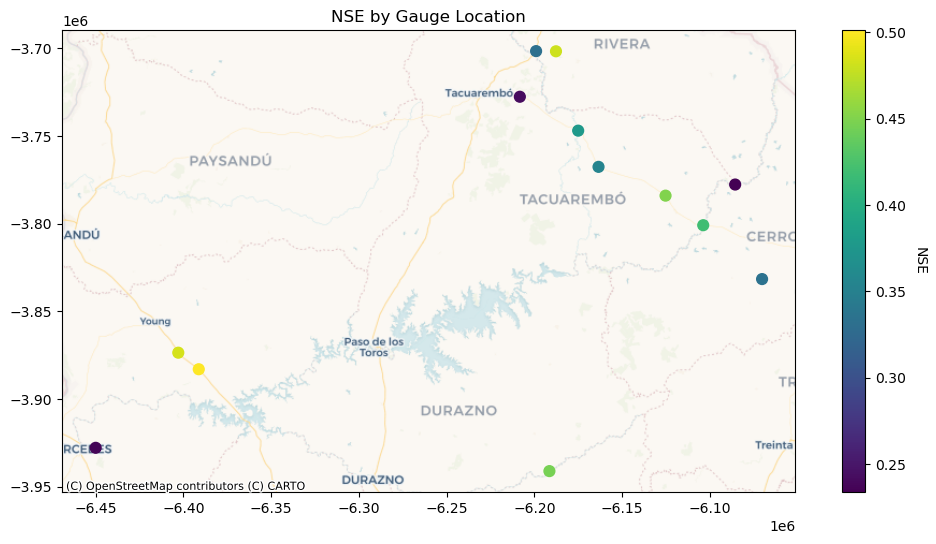

In [67]:
plot_nse_map(
    run_dir_name="rs24_h256_do0.4_seq_length270_1811_105843",
    period="validation"
)

## Hydrographs (validation)

In [55]:
def plot_validation_results(run_dir):
    """
    Plot validation results for a run, including NSE from CSV, and save plots.

    Parameters
    ----------
    run_dir : str or Path
        Path to the run's validation folder, e.g.,
        './runs/finetune_seq_365_both_2511_093159/validation/model_epoch050'
    """
    run_dir = Path(run_dir)
    # Run name is the parent of 'validation'
    run_name = run_dir.parents[1].name

    # Paths to validation results
    pickle_file = run_dir / "validation_results.p"
    metrics_file = run_dir / "validation_metrics.csv"

    # Load validation results
    with open(pickle_file, "rb") as f:
        results = pickle.load(f)
    
    # Load NSE/metrics CSV
    metrics_df = pd.read_csv(metrics_file)

    # Convert to dictionary for fast lookup
    nse_lookup = dict(zip(metrics_df['basin'], metrics_df['NSE']))

    # Ensure plot directory exists
    out_dir = PLOTS_DIR / run_name
    out_dir.mkdir(parents=True, exist_ok=True)

    # Loop over basins
    for basin_id, by_freq in results.items():
        # Only process CAMELS_UY basins
        if not str(basin_id).startswith("CAMELS_UY"):
            continue
        
        xr_block = by_freq["1D"]["xr"]

        # Automatically pick obs / sim variables
        data_vars = list(xr_block.data_vars)
        obs_var = next(k for k in data_vars if k.endswith("_obs"))
        sim_var = next(k for k in data_vars if k.endswith("_sim"))

        qobs = xr_block[obs_var]
        qsim = xr_block[sim_var]

        # Time coordinate
        time_coord = next((c for c in ["time","date","time_step"] if c in xr_block.coords), None)
        time = xr_block[time_coord].values if time_coord else range(qobs.shape[0])

        # Get NSE from CSV
        nse_val = nse_lookup.get(basin_id, float('nan'))

        # Plot
        plt.figure(figsize=(12, 4))
        plt.plot(time, qobs, label="Observed")
        plt.plot(time, qsim, label="Simulated")
        plt.title(f"Validation — Basin {basin_id} — NSE: {nse_val:.3f}")
        plt.xlabel("Date")
        plt.ylabel("Streamflow (mm/d)")
        plt.legend()
        plt.grid(alpha=0.3)

        # Save figure
        out_path = out_dir / f"basin_{basin_id}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close()

    print(f"Validation plots saved to: {out_dir.resolve()}")

In [68]:
run_dir = "./runs/rs24_h256_do0.4_seq_length270_1811_105843/validation/model_epoch030"
plot_validation_results(run_dir)

Validation plots saved to: /mmfs1/gscratch/stf/hernanqd/project/pruebas/Finetuning_camels_uy/evaluation_plots/rs24_h256_do0.4_seq_length270_1811_105843


In [83]:
# Load attributes
attributes = pd.read_csv(ATTRIBUTES_FILE)
attributes.columns = attributes.columns.str.strip()

# Keep only rows where gauge_id starts with CAMELS_UY
attributes = attributes[attributes["gauge_id"].str.startswith("CAMELS_UY")]
remove_ids = ["CAMELS_UY_1", "CAMELS_UY_4", "CAMELS_UY_13"]
attributes = attributes[~attributes["gauge_id"].isin(remove_ids)]

print(f"Gauges kept: {len(attributes)}")

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    attributes,
    geometry=gpd.points_from_xy(attributes["gauge_lon"], attributes["gauge_lat"]),
    crs="EPSG:4326"
)

# Convert for basemap
gdf_web = gdf.to_crs(epsg=3857)

Gauges kept: 13


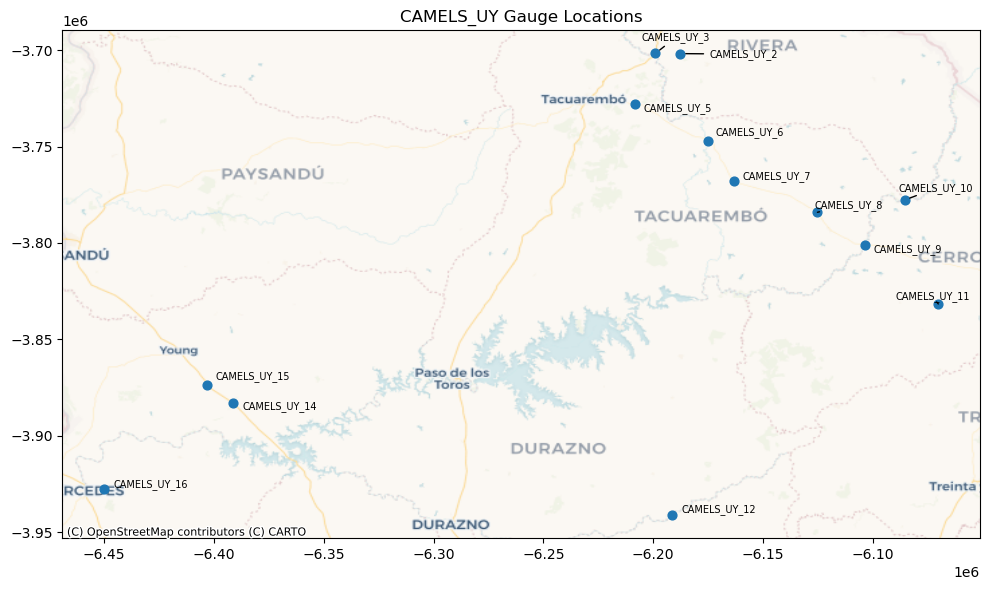

In [84]:
# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(gdf_web.geometry.x, gdf_web.geometry.y, s=40)

# Add labels near points
texts = []
for gauge_id, x, y in zip(attributes.gauge_id, gdf_web.geometry.x, gdf_web.geometry.y):
    texts.append(ax.text(x, y, gauge_id, fontsize=7))

# Automatically adjust label locations to prevent overlap
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", shrinkA=4, shrinkB=4))

# Basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

# Title & labels
ax.set_title("CAMELS_UY Gauge Locations")

plt.tight_layout()
plt.show()